# Quick Code Analysis

To get going with this notebook I suggest using VS Code with Python extension.

Create a virtual environment in this folder:

```
python -m venv .venv
```

Select the Python Interpreter from the venv in the quick command menu (Ctrl/Cmd + Shift + P) -> `> Python: Select Interpreter` (refresh the interpreter list or reload the window if it does not show up).

Open a terminal, load the venv if that's not done automatically, and install pandas:

```
pip install pandas
```

Ensure `git` can be be found.

Change the variables below to point to your repo of interest, and give this notebook a spin (VS Code may ask if it needs to install a Jupyter kernel).

In [8]:
# path = "/home/arjan/Projects/DeutscheBahn/py-capella-mbse"
path = "/home/arjan/Development/cpython"
after = "one year ago"
top = 10

# Regex patterns to exclude from analisys. E.g. generated files.
excludes = [".*\\.svg$", ".*\\.xcf", ".*\\.md", ".*\\.rst"]


In [9]:
import os
import re
import pandas

cwd = os.getcwd()
os.chdir(cwd)

os.chdir(path)

lines = []

compiled_excludes = [re.compile(ex) for ex in excludes]

for line in os.popen(f"git log --format=format:'::: %H,%ci,%an' --numstat --no-renames --after='{after}'").readlines():
    line = line.strip()
    if not line:
        continue
    elif line.startswith("::: "):
        meta = line.split(" ", 1)[1].split(",")
    else:
        try:
            added, removed, filename = line.split("\t", 2)
        except ValueError as e:
            print(f"'{line}': {e}")
            continue
        for ex in compiled_excludes:
            if re.search(ex, filename):
                break
        else:
            rec = [*meta, added, removed, filename]
            assert len(rec) == 6, rec
            lines.append(rec)

df = pandas.DataFrame(lines, columns=["date", "commit", "author", "added", "removed", "filename"])
df['dirname'] = df.apply(lambda row: os.path.dirname(row["filename"]), axis=1)
df['dirname2'] = df.apply(lambda row: os.path.dirname(row["dirname"]), axis=1)

del lines
df[:10]

,date,commit,author,added,removed,filename,dirname,dirname2
0,db3ff76da19004f266b62e98a81bdfd322861436,2021-06-28 10:26:18 +0200,Łukasz Langa,2,2,Include/patchlevel.h,Include,
1,db3ff76da19004f266b62e98a81bdfd322861436,2021-06-28 10:26:18 +0200,Łukasz Langa,21,17,Lib/pydoc_data/topics.py,Lib/pydoc_data,Lib
2,b2a5dcd8a0fe1e7bf4fd09ea7f08fc3ea4f71bc5,2021-06-27 11:50:45 -0700,Miss Islington (bot),24,3,Lib/abc.py,Lib,
3,4861fdaf25f246eb9ee4e8161c15dad26efe895d,2021-06-27 14:28:24 +0300,Serhiy Storchaka,7,2,Lib/glob.py,Lib,
4,fe272b7a3ace1542ef3f269763b408fbcb07b869,2021-06-26 18:59:57 +0100,Stéphane Bidoul,1,1,Lib/ensurepip/__init__.py,Lib/ensurepip,Lib
5,fe272b7a3ace1542ef3f269763b408fbcb07b869,2021-06-26 18:59:57 +0100,Stéphane Bidoul,-,-,Lib/ensurepip/_bundled/pip-21.1.1-py3-none-any...,Lib/ensurepip/_bundled,Lib/ensurepip
6,fe272b7a3ace1542ef3f269763b408fbcb07b869,2021-06-26 18:59:57 +0100,Stéphane Bidoul,-,-,Lib/ensurepip/_bundled/pip-21.1.3-py3-none-any...,Lib/ensurepip/_bundled,Lib/ensurepip
7,0796e21fea31fe7b697d84c8d03186817792c458,2021-06-24 05:25:41 -0700,Miss Islington (bot),8,3,Lib/test/test_ssl.py,Lib/test,Lib
8,5ed7827b1620f5b3729bc9767158d24a33863fa9,2021-06-23 17:47:33 +0200,Victor Stinner,15,3,Lib/test/test_embed.py,Lib/test,Lib
9,5ed7827b1620f5b3729bc9767158d24a33863fa9,2021-06-23 17:47:33 +0200,Victor Stinner,55,3,Programs/_testembed.c,Programs,


# Complexity

In [10]:
complexity = pandas.DataFrame([(line.strip(), os.stat(line.strip()).st_size) for line in os.popen(f"git ls-files").readlines()], columns=["filename", "size"]).sort_values("size", ascending=False)
complexity[:top]

,filename,size
3164,Misc/svnmap.txt,4289021
3573,Modules/unicodename_db.h,2217742
1205,Lib/ensurepip/_bundled/pip-21.1.3-py3-none-any...,1548027
117,Doc/data/python3.9.abi,1357002
3049,Misc/HISTORY,1355257
3902,Parser/pegen/parse.c,847209
4382,Tools/unicode/python-mappings/gb-18030-2000.xml,845975
1206,Lib/ensurepip/_bundled/setuptools-56.0.0-py3-n...,784941
1576,Lib/pydoc_data/topics.py,692230
3182,Modules/_blake2/impl/blake2-kat.h,656621


# Churn

Churn is simplyhow many times a file has changed in the history of a project. The more often it changed, the higher the "churn".

In [11]:
churn = df.groupby(['filename']).size().reset_index(name='commits').sort_values("commits", ascending=False)
churn[:top]

,filename,commits
363,Misc/ACKS,18
46,Include/patchlevel.h,17
353,Mac/BuildScript/build-installer.py,12
110,Lib/idlelib/NEWS.txt,12
98,Lib/enum.py,12
5,.github/workflows/build.yml,11
459,Parser/pegen/parse.c,10
291,Lib/test/test_ssl.py,10
233,Lib/test/test_enum.py,10
35,Grammar/python.gram,9


,filename,commits,size,churn_complexity
6,Parser/pegen/parse.c,10,847209,8472090
11,Lib/pydoc_data/topics.py,9,692230,6230070
16,configure,8,513952,4111616
20,Objects/unicodeobject.c,7,482737,3379159
18,Modules/posixmodule.c,8,415198,3321584
7,Lib/test/test_ssl.py,10,208877,2088770
15,Modules/_ssl.c,8,197513,1580104
428,Lib/ensurepip/_bundled/pip-21.1.3-py3-none-any...,1,1548027,1548027
17,configure.ac,8,174676,1397408
263,Doc/data/python3.9.abi,1,1357002,1357002


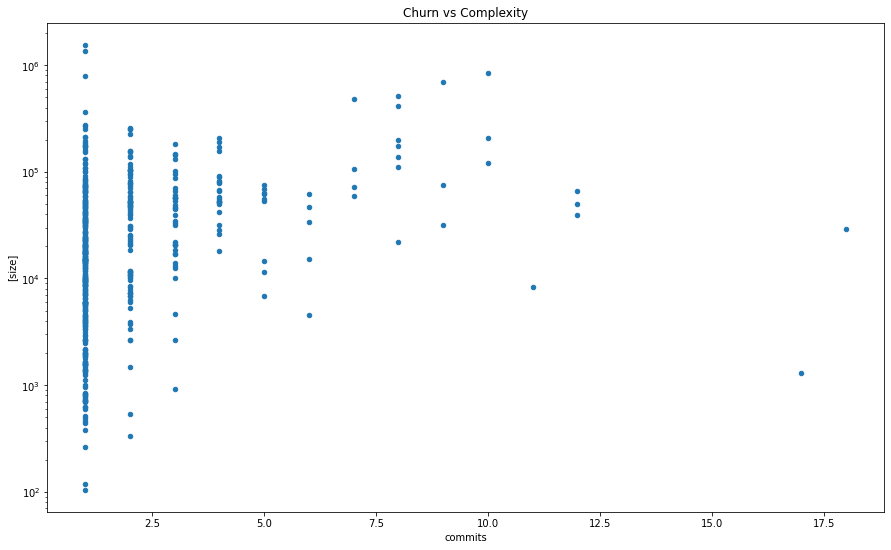

In [20]:
churn_complexity = pandas.merge(churn, complexity, on="filename", suffixes=("_ch", "_co"))
churn_complexity["churn_complexity"] = churn_complexity.apply(lambda row: row["commits"] * row["size"], axis=1)

churn_complexity.plot.scatter(x="commits", y=["size"], title="Churn vs Complexity", figsize=(15,9), logy=True, logx=False)

churn_complexity.sort_values("churn_complexity", ascending=False)[:top]

# Top authors

The authors that contributed most to the repository.

In [13]:
top_authors = df.groupby(['author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors[:top]

,author,commits
23,Miss Islington (bot),486
24,Miss Skeleton (bot),116
33,Serhiy Storchaka,54
7,Christian Heimes,41
27,Pablo Galindo,37
44,Łukasz Langa,28
34,Steve Dower,27
29,Ronald Oussoren,26
19,Lysandros Nikolaou,22
38,Victor Stinner,19


In [14]:
top_authors_per_package = df.groupby(['dirname', 'author']).size().reset_index(name='commits').sort_values("commits", ascending=False)
top_authors_per_package[:top]

,dirname,author,commits
125,Lib/test,Miss Islington (bot),99
56,Lib,Miss Islington (bot),73
90,Lib/idlelib,Miss Islington (bot),41
196,Modules,Miss Islington (bot),37
96,Lib/idlelib/idle_test,Miss Islington (bot),20
3,,Miss Islington (bot),18
19,Doc/includes/sqlite3,Miss Islington (bot),18
126,Lib/test,Miss Skeleton (bot),17
36,Include,Łukasz Langa,17
57,Lib,Miss Skeleton (bot),14


# Change Coupling

Change coupling tells us which files have a tendency to change together.

In [15]:
from IPython.core.display import HTML

combinations = {}
commits = {}

for _, group in df.groupby(['commit']):
    import itertools
    
    for name in group["filename"]:
        commits[name] = 1 + commits.get(name, 0)

    for pair in set(itertools.combinations(sorted(group['filename']), 2)):
        combinations[pair] = 1 + combinations.get(pair, 0)


change_coupling = sorted(((n / (n + commits[a] + commits[b]), n, a, b) for (a, b), n in combinations.items()), reverse=1)[:top*5]

rows = (
    f"""
    <tr><td>{n}</td><td>{file_a}</td><td>{commits[file_a]}</td><td>{int(n / commits[file_a] * 100)}</td></tr>
    <tr><td></td><td>{file_b}</td><td>{commits[file_b]}</td><td>{int(n / commits[file_b] * 100)}</td></tr>
    """ for _, n, file_a, file_b in change_coupling)

HTML(f"<table><th><td>Coupled Entities</td><td>Commits</td><td>% coupling</td></th>{''.join(rows)}</table>")

8,configure,8,100
,configure.ac,8,100
6,PCbuild/get_externals.bat,6,100
,PCbuild/python.props,6,100
4,Lib/test/test_urlparse.py,4,100
,Lib/urllib/parse.py,4,100
3,Lib/distutils/tests/test_build_ext.py,3,100
,Lib/test/test_posix.py,3,100
2,Python/pystate.c,2,100
,Python/sysmodule.c,2,100
2,Python/errors.c,2,100
